# Spectral Diffusion for a Toy ${\rm SU}(2)$ Model using Group-Valued Score Matching

In this notebook, we apply the same machinery we used in the other notebook (where we trained a score network to learn the heat kernel and denoise the variance-expanding diffusion process) to learn a toy theory involving a single ${\rm SU}(2)$ matrix $U$ (one independent eigenangle $\theta$).

## Setup

In [1]:
import math
import torch
import numpy as np

import tqdm.auto as tqdm
import matplotlib as mpl
import matplotlib.pyplot as plt

In [2]:
import sys
sys.path.insert(0, '..')  # repo analysis library
import analysis as al

In [3]:
import sun_diffusion

from sun_diffusion.action import SUNToyPolynomialAction
from sun_diffusion.sun import (
    mat_angle, adjoint,
    extract_diag, embed_diag,
    random_sun_element, random_un_haar_element,
)
from sun_diffusion.diffusion import VarianceExpandingDiffusionSUN, PowerDiffusionSUN
from sun_diffusion.heat import sun_score_hk
from sun_diffusion.utils import grab, compute_ess, compute_kl_div

In [4]:
from sun_diffusion.devices import get_device, get_dtype, set_device, summary
set_device('cuda', 0)
print(summary())

Using device: cuda:0 (NVIDIA GH200 120GB) with dtype: torch.float32


## Define a Target Theory and Generate Training Data

The target theory whose distribution we will try to reproduce is specified by a toy action of our choosing, which we define to be 
$$S_i(U) = -\frac{\beta}{2} {\rm Re}{\rm Tr}\left[\sum_n c_n U^n\right].$$

In [65]:
Nc = 2
beta = 1.0
coeffs_dict = {
    0: [1.0, 0., 0.],
    1: [0.17, -0.65, 1.22],
    2: [0.98, -0.63, -0.21]
}  # from Table I of [2008.05456]

coeffs = 1  # change this to try other coefficient sets
action = SUNToyPolynomialAction(beta, coeffs_dict[coeffs])

To generate configurations, we will use the Metropolis algorithm for simplicity.

In [66]:
def apply_metropolis(batch_size, Nc, action, num_therm, num_iters, step_size, save_freq=10):
    """Batched Metropolis sampler."""
    action_vals = []
    accept_rates = []
    
    U = random_sun_element(batch_size, Nc=Nc)
    ens = []
    for i in tqdm.tqdm(range(-num_therm, num_iters)):
        # Proposal
        V = random_sun_element(batch_size, Nc=Nc, scale=step_size)
        Up = V @ U
        dS = action(Up) - action(U)

        # Accept / Reject
        r = torch.rand(batch_size)  # accept w/ prob = exp(-dS)
        accept_mask = (r < torch.exp(-dS))[:, None, None]
        U = torch.where(accept_mask, Up, U)

        action_vals.append(grab(action(U).mean()))
        accept_rates.append(grab(torch.sum(accept_mask) / batch_size))
        if i >= 0 and (i+1) % save_freq == 0:
            ens.append(U)
    return torch.cat(ens), action_vals, accept_rates

In [67]:
# Generate samples
batch_size = 32
num_therm = 1_000
num_iters = 10_240
save_freq = 10
step_size = 0.9

num_train = batch_size * (num_iters // save_freq)
print(f'{num_train=}')

U_train, action_vals, accept_rates = apply_metropolis(
    batch_size = batch_size,
    Nc = Nc,
    action = action,
    num_therm = num_therm,
    num_iters = num_iters,
    step_size = step_size
)
print('U_train shape:', U_train.shape)

num_train=32768


  0%|          | 0/11240 [00:00<?, ?it/s]

U_train shape: torch.Size([32768, 2, 2])


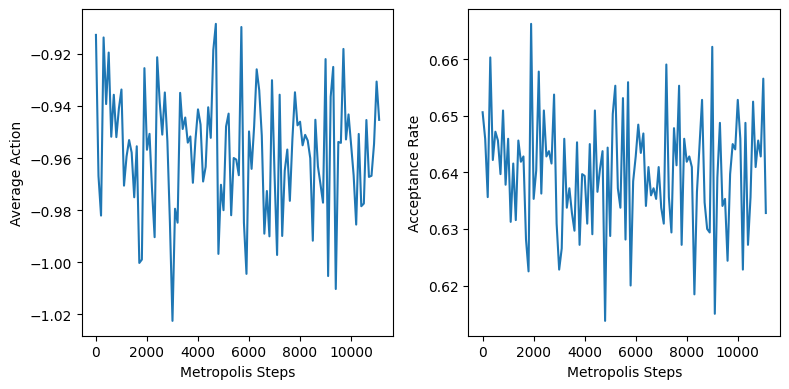

In [68]:
# Visualize Metropolis
fig, axes = plt.subplots(1, 2, figsize=(8, 4))
for ax in axes:
    ax.set_xlabel('Metropolis Steps')

axes[0].plot(*al.bin_data(action_vals, binsize=100))
axes[0].set_ylabel('Average Action')

axes[1].plot(*al.bin_data(accept_rates, binsize=100))
axes[1].set_ylabel('Acceptance Rate')

fig.tight_layout()
plt.show()

ps shape: torch.Size([101])


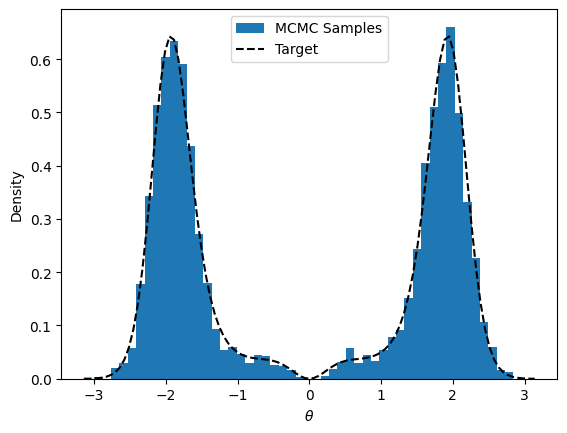

In [69]:
fig, ax = plt.subplots(1, 1)
ax.hist(grab(mat_angle(U_train[::10])[0][:, 0]), bins=50, density=True, label='MCMC Samples')
ths = torch.linspace(-np.pi, np.pi, steps=101)
dth = ths[1] - ths[0]
ths = torch.stack([ths, -ths], dim=-1)
ps = torch.exp(-action.value_eigs(ths)) * torch.sin(ths[:, 0])**2
ps /= torch.sum(ps * dth, dim=-1, keepdims=True)
print('ps shape:', ps.shape)
ax.plot(grab(ths[:, 0]), grab(ps), color='k', linestyle='--', label='Target')
ax.set_xlabel(r'$\theta$')
ax.set_ylabel('Density')

ax.legend()
fig.show()

  0%|          | 0/8 [00:00<?, ?it/s]

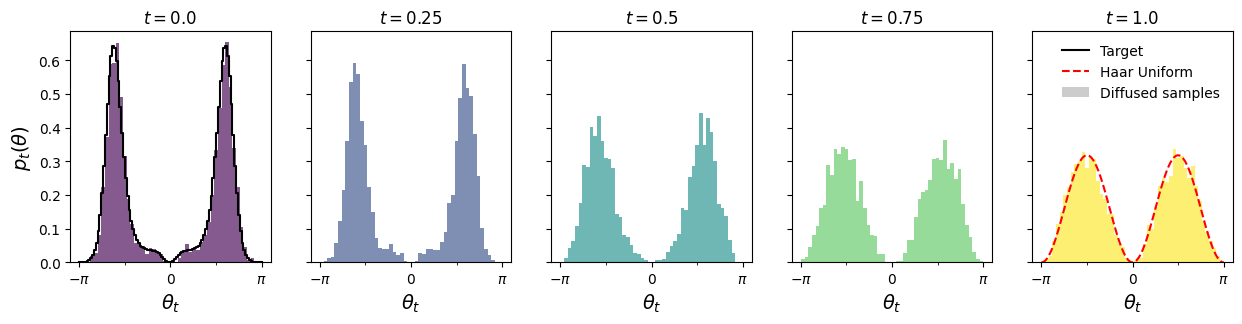

In [70]:
kappa = 3.0
# diffuser = VarianceExpandingDiffusionSUN(kappa)
diffuser = PowerDiffusionSUN(kappa, alpha=1)

times = [0.0, 0.25, 0.5, 0.75, 1.0]
cmap = mpl.colormaps.get_cmap('viridis')
fig, axes = plt.subplots(1, len(times), figsize=(3*len(times), 3), sharey=True)
axes[0].set_ylabel(r'$p_t(\theta)$', fontsize=14)

bins = np.linspace(-np.pi, np.pi, num=51)

U_0 = U_train.clone()[::10]
for t, ax in zip(times, axes):
    if t == 0:  # avoid sampling from HK at t=0
        x_t, _, _ = mat_angle(U_0)
    else:
        U_t, _, _ = diffuser.diffuse(U_0, t*torch.ones(U_0.size(0)), n_iter=15)
        x_t, _, _ = mat_angle(U_t)
    ax.hist(grab(x_t[:, 0]), bins=bins, density=True, color=cmap(t), alpha=0.65)
    ax.set_xlabel(r'$\theta_t$', fontsize=14)
    ax.set_title(f'$t = {t}$')
    ax.set_xticks([-np.pi, 0, np.pi])
    ax.set_xticklabels([r"$-\pi$", r"$0$", r"$\pi$"])
    ax.xaxis.set_minor_locator(mpl.ticker.FixedLocator([-np.pi/2, np.pi/2]))
    ax.tick_params(axis='y', labelsize=10)
    ax.tick_params(axis='x', labelsize=10)

# also save histograms for future comparisons
true_times = [1.0, 0.75, 0.5, 0.25, 0.15, 0.10, 0.05, 0.01]
true_hists = []
for t in tqdm.tqdm(true_times):
    hist_xt = np.zeros(len(bins)-1, dtype=np.float64)
    for chunk_U in torch.chunk(U_0, 10):
        U_t, _, _ = diffuser.diffuse(chunk_U, t*torch.ones(chunk_U.size(0)), n_iter=15)
        x_t, _, _ = mat_angle(U_t)
        hist_xt += np.histogram(grab(x_t[:, 0]), bins=bins)[0]
    hist_xt /= U_0.size(0) * (bins[1]-bins[0])
    true_hists.append((bins, hist_xt))

# Target density
ths = torch.linspace(-np.pi, np.pi, steps=101)
dth = grab(ths[1]-ths[0])
ths = torch.stack([ths, -ths], dim=-1)
ps = grab((-action.value_eigs(ths)).exp()) * np.sin(grab(ths[:,0]))**2
ps /= np.sum(ps, axis=-1, keepdims=True) * dth
target_line, = axes[0].step(grab(ths[:, 0]), ps, color='k', label='Target')

# Haar uniform
xs = torch.linspace(-np.pi, np.pi, 100)
haar = (1 / np.pi) * torch.sin(xs)**2
haar_line, = axes[-1].plot(grab(xs), grab(haar), ls='--', color='red', label='Haar Uniform')

sample_patch = mpl.patches.Patch(facecolor='gray', alpha=0.4, label='Diffused samples')
axes[-1].legend(
    handles=[target_line, haar_line, sample_patch],
    loc='upper right',
    frameon=False
)

plt.show()

## Train a Score Network

Now we must construct a score network that will take as input the eigenangle $\theta$ and time $t$.

In [71]:
class SU2ScoreNet(torch.nn.Module):
    def __init__(self, input_dim=3, hidden_dim=8):
        super().__init__()
        assert input_dim % 2 == 1
        self.nk = (input_dim - 1)//2
        self.net = torch.nn.Sequential(
            # input_dim = 1 eigenangle + encoded time
            torch.nn.Linear(input_dim, hidden_dim),
            torch.nn.SiLU(),
            torch.nn.Linear(hidden_dim, hidden_dim),
            torch.nn.SiLU(),
            torch.nn.Linear(hidden_dim, hidden_dim),
            torch.nn.SiLU(),
            torch.nn.Linear(hidden_dim, 1))
        
    def forward(self, x_t, t):
        assert len(x_t.shape) == 2, \
            'input eigenangles shape should be [batch_size, Nc-1]'
        assert len(t.shape) == 1, \
            'times should only have a batch dimension'
        cos_t = torch.cos(torch.exp(-10.0*(torch.arange(1,self.nk+1)/self.nk - 0.5))*t.unsqueeze(-1))
        sin_t = torch.sin(torch.exp(-10.0*(torch.arange(1,self.nk+1)/self.nk - 0.5))*t.unsqueeze(-1))
        inp = torch.cat([x_t, cos_t, sin_t], dim=-1)
        return self.net(inp) * torch.sin(x_t) # enforce score -> 0 at endpoints


def _test_su2_score_net():
    batch_size = 10
    Nc = 2
    x = 2*np.pi*torch.rand((batch_size, 1)) - np.pi
    t = torch.rand((batch_size,))
    s_t = SU2ScoreNet()(x, t)

    assert s_t.shape == x.shape, \
        '[FAILED: score net output must have same shape as input data]'
    print('[PASSED]')

_test_su2_score_net()

[PASSED]


Define the loss functions

In [72]:
def score_matching_loss_sun(U_0, diffuser, score_net, tol=1e-4):
    batch_size = U_0.size(0)
    t = tol + (1 - tol) * torch.rand(batch_size)
    sigma_t = diffuser.sigma_func(t)

    U_t, xs, V = diffuser.diffuse(U_0, t, n_iter=25)
    x_t, P, Pinv = mat_angle(U_t)

    score = score_net(x_t[..., :-1], t)
    # NOTE(gkanwar): Passing xs instead of (x_t - x_0) is important here
    true_score_xs = sun_score_hk(xs[..., :-1], width=sigma_t)
    true_score = extract_diag(Pinv @ V @ embed_diag(true_score_xs).to(V) @ adjoint(V) @ P).real[...,:-1]

    # NOTE(gkanwar): Scaling by sigma_t^2 results in a roughly constant variance,
    # making training much more stable.
    diff = score - true_score
    loss = torch.mean(sigma_t[:, None]**2 * diff**2)
    return loss

In [73]:
def force_matching_loss_sun(U_0, action, score_net):
    """Computes the force-matching regularization term."""
    batch_size = U_0.size(0)
    x_0, _, _ = mat_angle(U_0)
    
    # True force ~ learned force @t=0
    force = action.force_eigs(x_0)
    score = score_net(x_0[..., :-1], torch.zeros(batch_size))
    return torch.mean((force - score)**2)

Do the training

In [ ]:
from torch.utils.data import DataLoader, TensorDataset

# Make diffusion process
kappa = 3.0
alpha = 1.0
diffuser = PowerDiffusionSUN(kappa, alpha)
#diffuser = VarianceExpandingDiffusionSUN(kappa)

score_net = SU2ScoreNet(input_dim=51, hidden_dim=64)

# Setup training hyperparams
epochs = 100
reg_coeff = 0.1
lr = 1e-3
optimizer = torch.optim.Adam(params=score_net.parameters(), lr=lr)

# Prepare dataloader
batch_size = 1024
dataset = TensorDataset(U_train) 
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, generator=torch.Generator(device=get_device()))

# Training loop
losses = []
score_net.train()
for epoch in tqdm.tqdm(range(epochs)):
    total_loss = 0.0
    for batch_idx, (U_0_batch,) in enumerate(tqdm.tqdm(dataloader, leave=False)):
        optimizer.zero_grad()
        sm_loss = score_matching_loss_sun(U_0_batch, diffuser, score_net)
        #fm_loss = force_matching_loss_sun(U_0_batch, action, score_net)
        loss = sm_loss #+ reg_coeff*fm_loss
        loss.backward()
        optimizer.step()
        total_loss += grab(loss)
        losses.append(grab(loss))
    avg_loss = total_loss / len(dataloader)
    print(f'Epoch {epoch}/{epochs} | Loss = {avg_loss:.6f}')
    # losses.append(avg_loss)

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 0/100 | Loss = 0.311663


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 1/100 | Loss = 0.304492


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 2/100 | Loss = 0.305957


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 3/100 | Loss = 0.305768


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 4/100 | Loss = 0.303933


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 5/100 | Loss = 0.299960


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 6/100 | Loss = 0.303665


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 7/100 | Loss = 0.301060


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 8/100 | Loss = 0.296955


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 9/100 | Loss = 0.292686


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 10/100 | Loss = 0.292213


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 11/100 | Loss = 0.296553


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 12/100 | Loss = 0.297563


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 13/100 | Loss = 0.292312


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 14/100 | Loss = 0.284285


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 15/100 | Loss = 0.291444


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 16/100 | Loss = 0.292660


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 17/100 | Loss = 0.287077


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 18/100 | Loss = 0.288156


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 19/100 | Loss = 0.288363


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 20/100 | Loss = 0.289406


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 21/100 | Loss = 0.286404


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 22/100 | Loss = 0.290569


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 23/100 | Loss = 0.284989


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 24/100 | Loss = 0.288020


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 25/100 | Loss = 0.288646


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 26/100 | Loss = 0.286307


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 27/100 | Loss = 0.289152


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 28/100 | Loss = 0.288461


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 29/100 | Loss = 0.282186


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 30/100 | Loss = 0.282531


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 31/100 | Loss = 0.283610


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 32/100 | Loss = 0.286536


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 33/100 | Loss = 0.284327


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 34/100 | Loss = 0.287277


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 35/100 | Loss = 0.285647


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 36/100 | Loss = 0.284867


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 37/100 | Loss = 0.287410


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 38/100 | Loss = 0.284921


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 39/100 | Loss = 0.290222


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 40/100 | Loss = 0.286001


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 41/100 | Loss = 0.282379


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 42/100 | Loss = 0.284593


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 43/100 | Loss = 0.289189


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 44/100 | Loss = 0.284505


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 45/100 | Loss = 0.283854


  0%|          | 0/32 [00:00<?, ?it/s]

In [ ]:
# Plot training loss vs epochs
fig, ax = plt.subplots(1, 1, figsize=(6, 2.5))
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')
xs, ys = al.bin_data(losses, binsize=25)
xs = xs / (num_train/batch_size) # convert to epochs
ax.plot(xs, ys, lw=0.75)
fig.set_tight_layout(True)
plt.show()

  0%|          | 0/6 [00:00<?, ?it/s]

t=0.05 sigma(t)=0.019364916731037088


  0%|          | 0/50 [00:00<?, ?it/s]

t=0.1 sigma(t)=0.05477225575051662


  0%|          | 0/50 [00:00<?, ?it/s]

t=0.25 sigma(t)=0.21650635094610965


  0%|          | 0/50 [00:00<?, ?it/s]

t=0.5 sigma(t)=0.6123724356957945


  0%|          | 0/50 [00:00<?, ?it/s]

t=0.75 sigma(t)=1.125


/tmp/ipykernel_1198244/2687820178.py:45: RuntimeWarning: invalid value encountered in divide
  f=lambda x,c: np.sum(x, axis=0)/np.sum(c, axis=0))


  0%|          | 0/50 [00:00<?, ?it/s]

t=1.0 sigma(t)=1.7320508075688772


  0%|          | 0/50 [00:00<?, ?it/s]

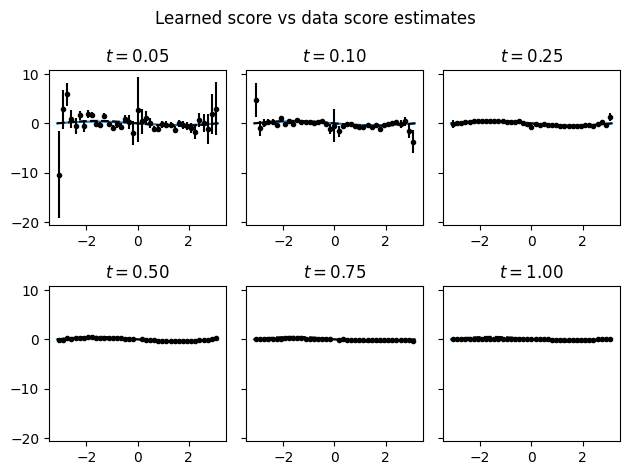

In [16]:
# Check evaluated score vs noisy
def _check_score():
    U_0 = U_train.clone()
    batch_size = U_0.size(0)

    bins = np.linspace(-np.pi, np.pi, num=40)

    ts = [0.05, 0.1, 0.25, 0.5, 0.75, 1.0]
    fig, axes = plt.subplots(2, 3, sharey=True)
    for t_sc, ax in zip(tqdm.tqdm(ts), axes.flatten()):
        print(f't={t_sc} sigma(t)={grab(diffuser.sigma_func(t_sc))}')
        # t = tol + (1 - tol) * torch.rand((batch_size,))

        true_chunks = []
        true_counts_chunks = []
        for U_chunk in tqdm.tqdm(torch.chunk(U_0, 50), leave=False):
            true = np.zeros(len(bins)-1, dtype=np.float64)
            true_counts = np.zeros(len(bins)-1)
            for _ in range(2):
                t = t_sc * torch.ones((U_chunk.size(0),))
                sigma_t = diffuser.sigma_func(t)
                U_t, xs, V = diffuser.diffuse(U_chunk, t, n_iter=50)
                # x_0, _, _ = mat_angle(U_0)
                x_t, P, Pinv = mat_angle(U_t)
                x_t = x_t.to(dtype=t.dtype)

                true_score_xs = sun_score_hk(xs[..., :-1], width=sigma_t)
                true_score = extract_diag(Pinv @ V @ embed_diag(true_score_xs).to(V) @ adjoint(V) @ P).real[...,:-1]
                true += np.histogram(grab(x_t[...,0]), weights=grab(true_score[...,0]), bins=bins)[0]
                true_counts += np.histogram(grab(x_t[...,0]), bins=bins)[0]
            true_chunks.append(true)
            true_counts_chunks.append(true_counts)

        # NN score
        xs_plot = np.linspace(-np.pi, np.pi, num=101)
        xs_eval = torch.tensor(xs_plot).to(get_dtype()).unsqueeze(-1)
        score = score_net(xs_eval, t_sc * torch.ones((len(xs_plot),)))
        ax.plot(xs_plot, grab(score[...,0]))

        # est of true score
        true_chunks = np.stack(true_chunks)
        true_counts_chunks = np.stack(true_counts_chunks)
        est_true = al.bootstrap(
            true_chunks, true_counts_chunks, Nboot=1000,
            f=lambda x,c: np.sum(x, axis=0)/np.sum(c, axis=0))
        xs = (bins[1:]+bins[:-1])/2
        # ax.plot(xs, true/true_counts, color='k')
        al.add_errorbar(est_true, ax=ax, xs=xs, color='k', linestyle='', marker='.')
        # ax.plot(grab(x_t[..., 0]), grab(true_score[...,0]), marker='x', linestyle='')

        # force corresponding to t=0 score
        Fs = grab(action.force_eigs(torch.tensor(np.stack([xs_plot, -xs_plot], axis=-1)))[:,0])
        ax.plot(xs_plot, Fs, color='k', linestyle='--')

        ax.set_title(rf'$t = {t_sc:.02f}$')
    fig.set_tight_layout(True)
    fig.suptitle('Learned score vs data score estimates')
    plt.show()
_check_score()

In [29]:
def grad_log_haar_su2(theta):
    eps = 1e-3 
    # gradient of log(sin^2(theta/2)) = cot(theta/2)
    delta = (theta + np.pi) % (2*np.pi) - np.pi  # wrap to [-pi, pi]
    delta = torch.clamp(delta, min=eps, max=np.pi - eps)  # avoid 0 or pi
    return 1.0 / torch.tan(delta / 2)

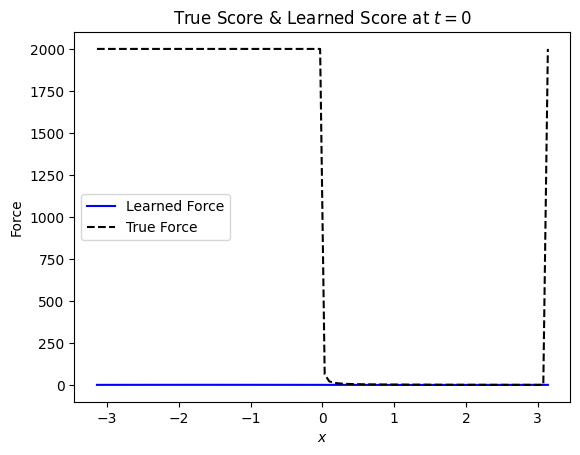

In [30]:
# Visualize score net at t=0 vs true force
fig, ax = plt.subplots(1, 1)

xs_eval = torch.linspace(-np.pi, np.pi, 100)

sigma_0 = diffuser.sigma_func(1e-3)
learned_force = score_net(xs_eval.unsqueeze(-1), torch.zeros(len(xs_eval)))
true_force = action.force_eigs(xs_eval) + grad_log_haar_su2(xs_eval)

ax.plot(grab(xs_eval), grab(learned_force), color='blue', label='Learned Force')
ax.plot(grab(xs_eval), grab(true_force), color='black', ls='--', label='True Force')
ax.set_xlabel('$x$')
ax.set_ylabel('Force')
ax.set_title('True Score & Learned Score at $t=0$')

ax.legend()
fig.show()

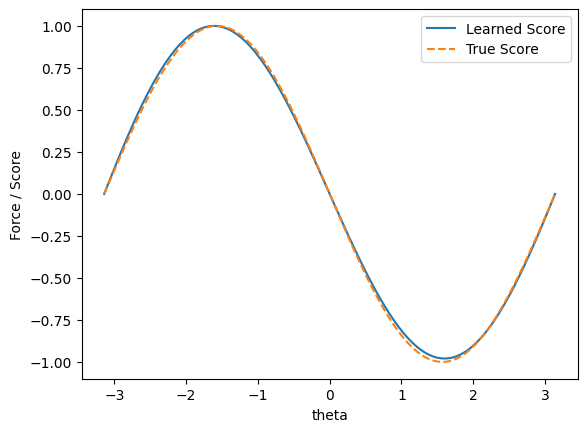

In [64]:
xs_eval = torch.linspace(-np.pi, np.pi, 200)
learned_score = score_net(xs_eval.unsqueeze(-1), 1e-3 + torch.zeros(len(xs_eval))) 
learned_score /= learned_score.abs().max()
#learned_score = torch.clamp(learned_score, -1e-2, 1e-2)

# True gradient of log density
S_grad = action.force_eigs(xs_eval)        # -dS/dtheta
haar_grad = 1.0 / torch.tan((xs_eval + np.pi) % (2*np.pi) - np.pi)  # stable

true_score = S_grad 
true_score /= true_score.abs().max()

plt.plot(grab(xs_eval), grab(learned_score), label="Learned Score")
plt.plot(grab(xs_eval), grab(true_score), '--', label="True Score")
plt.xlabel("theta")
plt.ylabel("Force / Score")
plt.legend()
plt.show()


In [59]:
ratio = learned_score / true_score
print("Mean ratio:", ratio.mean().item())
print("Max ratio:", ratio.max().item())


Mean ratio: -0.002050000010058284
Max ratio: 22877334.0


In [49]:
true_force.shape

torch.Size([100])

ratio shape: torch.Size([20000])


ValueError: x and y must have same first dimension, but have shapes (200,) and (100,)

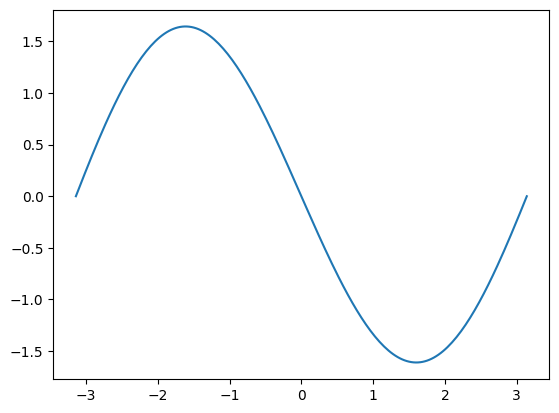

In [46]:
# Flatten for stability
ratio = (learned_score / true_force).flatten()
# Compute median or robust mean, ignoring extreme outliers
scale = torch.median(ratio[(ratio > 0.01) & (ratio < 10)])
print('ratio shape:', ratio.shape)
learned_score_scaled = learned_score / scale

# Then plot
plt.plot(grab(xs_eval), grab(learned_score_scaled), label="Learned score (rescaled)")
plt.plot(grab(xs_eval), grab(true_force), '--', label="True force")

## Denoising Process

Now we run the reverse process to generate new samples.

In [19]:
def sample_sun_gaussian(shape):
    Nc, Nc_ = shape[-2:]
    assert Nc == Nc_
    return proj_to_algebra(torch.randn(shape) + 1j*torch.randn(shape))

In [26]:
@torch.no_grad()
def solve_reverse_ODE_eigs(U_1, logr, score_net, diffuser, num_steps=200, verbose=False):
    trajectories = {
        'U_t': [],
        'logp': [],
        'logq': [],
        'kl_div': [],
        'ess': [],
        't': [],
        'Z': [],
    }
    dt = 1 / num_steps
    t = 1.0
    batch_size = U_1.size(0)
    x_1, V, V_inv = mat_angle(U_1)
    x_t = x_1.clone()

    logJ = 0.
    for step in tqdm.tqdm(range(num_steps)):
        # Get ODE params
        sigma_t = diffuser.sigma_func(t)
        g_t = diffuser.noise_coeff(t)
        score = score_net(x_t[..., :-1], t*torch.ones((batch_size,)))
        jac = torch.func.vmap(torch.func.jacfwd(lambda x: score_net(x[None], torch.tensor(t)[None])[0]))(x_t[..., :-1])
        div = torch.einsum('...ii->...', jac)
        
        # Integration step in reverse time
        score = torch.cat([score, -score.sum(-1, keepdim=True)], dim=-1)
        x_t = x_t + 0.5 * g_t**2 * score * dt
        logJ = logJ + 0.5 * g_t**2 * div * dt

        # Eigen-recomposition
        D = embed_diag(torch.exp(1j * x_t)).to(V)
        U_t = V @ D @ V_inv
        t -= dt

        # Collect and print metrics
        logp = -action(U_t) + log_haar_su2(x_t)
        logq = logr - logJ
        Z = al.bootstrap(grab((logp - logq).exp()), Nboot=1000, f=al.rmean)
        kl_div = al.bootstrap(grab(logp), grab(logq), Nboot=1000, f=compute_kl_div)
        ess = al.bootstrap(grab(logp), grab(logq), Nboot=1000, f=compute_ess)
        if verbose and step % 20 == 0:
            print(f'Step {step}/{num_steps}')
            print('logp =', logp.mean().item())
            print('logq =', logq.mean().item())
            print('Dkl =', kl_div)
            print('ESS =', ess)
            print()
        trajectories['t'].append(t)
        trajectories['U_t'].append(grab(U_t))
        trajectories['logp'].append(al.bootstrap(grab(logp), Nboot=1000, f=al.rmean))
        trajectories['logq'].append(al.bootstrap(grab(logq), Nboot=1000, f=al.rmean))
        trajectories['kl_div'].append(kl_div)
        trajectories['ess'].append(ess)
        trajectories['Z'].append(Z)

    for key in ['Z', 'kl_div', 'ess', 'logp', 'logq']:
        trajectories[key] = np.stack(trajectories[key], axis=1)
    
    return U_t, logJ, trajectories

In [27]:
def log_haar_su2(x):
    """Computes log likelihood of SU(2) Haar uniform density."""
    x = x[:, 0]
    log_sin2 = 2*torch.log(torch.abs(torch.sin(x)))
    log_norm = math.log(np.pi)
    return log_sin2 - log_norm

In [28]:
#num_samples = batch_size
num_samples = 4096
Nc = 2
U_1 = random_un_haar_element(num_samples, Nc=Nc)
U_1 *= (torch.linalg.det(U_1)**(-1/Nc) * torch.exp(2j*np.pi*torch.randint(Nc, size=(num_samples,))/Nc))[...,None,None]

In [29]:
# Get prior log likelihood
x_1, _, _ = mat_angle(U_1)
logr = log_haar_su2(x_1)
print('avg logr =', logr.mean().item())
print('std logr =', logr.std().item())

avg logr = -1.5378239154815674
std logr = 0.5461841225624084


In [30]:
U_0, logJ, history = solve_reverse_ODE_eigs(U_1, logr, score_net, diffuser, num_steps=200, verbose=True)
x_0, _, _ = mat_angle(U_0)

  0%|          | 0/200 [00:00<?, ?it/s]

Step 0/200
logp = -1.5341795682907104
logq = -1.5377063751220703
Dkl = (-0.0036838327, 0.007915913)
ESS = (0.8028319862816109, 0.002678550539913016)

Step 20/200
logp = -1.5140947103500366
logq = -1.5353591442108154
Dkl = (-0.021370865, 0.007181171)
ESS = (0.8275328227933588, 0.0023933277450987945)

Step 40/200
logp = -1.4851353168487549
logq = -1.531996726989746
Dkl = (-0.047059275, 0.006146456)
ESS = (0.8659624853131288, 0.001894349345261045)

Step 60/200
logp = -1.4539039134979248
logq = -1.5269851684570312
Dkl = (-0.07310114, 0.0052753054)
ESS = (0.908549498386145, 0.0013151950035069759)

Step 80/200
logp = -1.424882173538208
logq = -1.5200321674346924
Dkl = (-0.09512831, 0.0038746053)
ESS = (0.9473055133406313, 0.0008211467703401642)

Step 100/200
logp = -1.4019396305084229
logq = -1.5119190216064453
Dkl = (-0.10984052, 0.0025781584)
ESS = (0.9750451543121087, 0.0003968663314591182)

Step 120/200
logp = -1.3871475458145142
logq = -1.504555583000183
Dkl = (-0.11739488, 0.0016544823

/u/octavio5/projects/sun_diffusion/venv/lib/python3.10/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


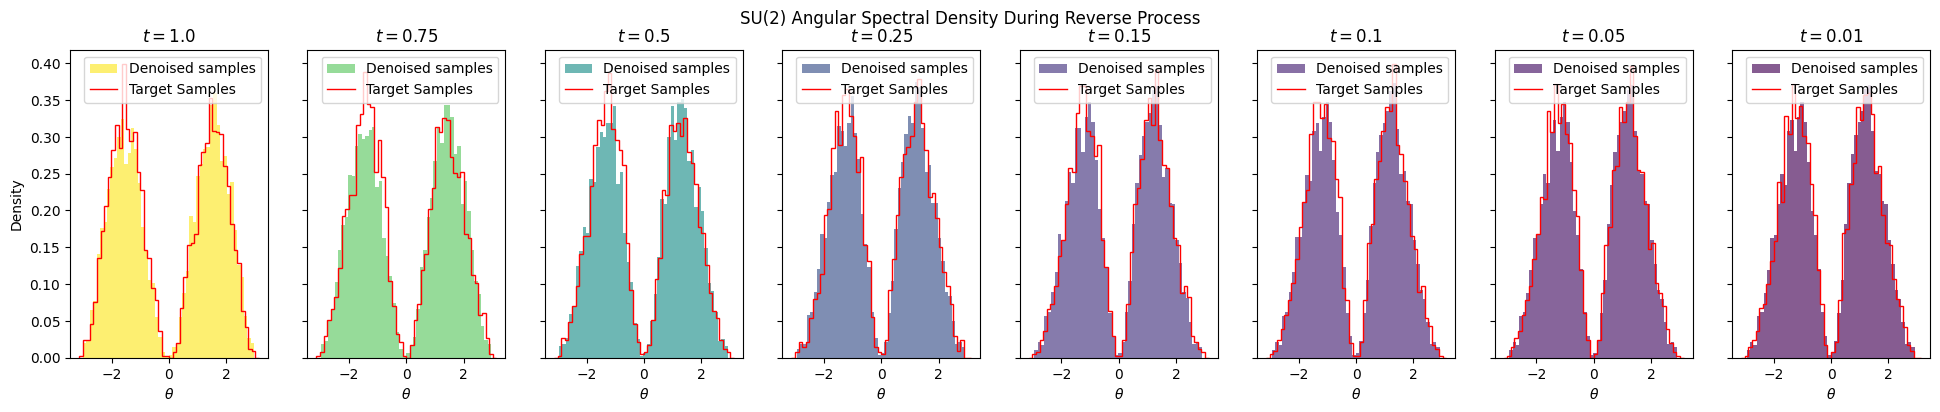

In [31]:
# Plot reverse trajectories
# times = [1.0, 0.75, 0.5, 0.25, 0.15, 0.01]
times = true_times
cmap = mpl.colormaps.get_cmap('viridis')
fig, axes = plt.subplots(1, len(times), figsize=(3*len(times), 4), sharey=True)
fig.suptitle('SU(2) Angular Spectral Density During Reverse Process')
axes[0].set_ylabel('Density')
xs = torch.linspace(-np.pi, np.pi, 100).unsqueeze(-1)
for t, hist, ax in zip(times, true_hists, axes):
    # Histogram denoised samples
    step = int((1 - t) * len(history['U_t']))
    U_t = torch.tensor(history['U_t'][step])
    x_t, _, _ = mat_angle(U_t)
    ax.hist(grab(x_t[:, 0]), bins=50, density=True, color=cmap(t), alpha=0.65, label='Denoised samples')
    ax.stairs(hist[1], hist[0], ec='red', color='none', label='Target Samples') # width=hist[1][1]-hist[1][0]
    # ax.hist(grab(mat_angle(U_train)[0][:, 0]), bins=50, histtype='step', density=True, color='red', label='Target Samples')
    # integrate score to get model distribution
    sigma_t = max(0.1, diffuser.sigma_func(t))
    bx = score_net(xs, t*torch.ones((xs.size(0),)))[...,0] / sigma_t**2
    logp_hat = torch.cumsum(bx, dim=-1) * (xs[1,0]-xs[0,0])
    p = grab((logp_hat + log_haar_su2(xs)).exp())
    p /= np.sum(p)*grab(xs[1,0]-xs[0,0])
    #ax.plot(grab(xs), grab(p), color='k', label='Model p(t)')
    # Plot
    ax.set_title(f'$t = {t}$')
    ax.set_xlabel(r'$\theta$')
    ax.legend()
plt.show()

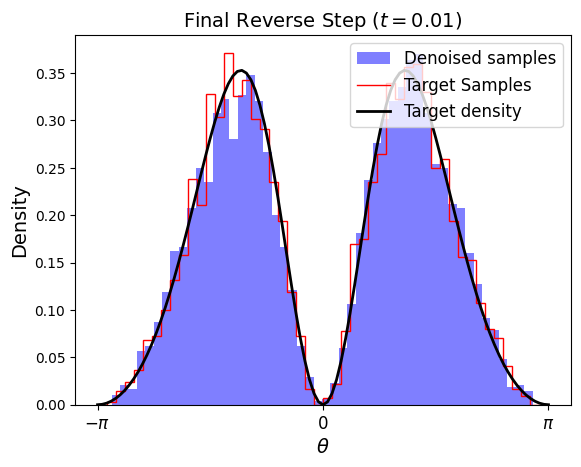

In [32]:
fig, ax = plt.subplots(1, 1)
t = times[-1]
hist = true_hists[-1]

# Histogram denoised samples
step = int((1 - t) * len(history['U_t']))
U_t = torch.tensor(history['U_t'][step])
x_t, _, _ = mat_angle(U_t)

ax.hist(grab(x_t[:, 0]), bins=50, density=True, color='blue', alpha=0.5, label='Denoised samples')
ax.stairs(hist[1], hist[0], ec='red', color='none', label='Target Samples')

# Analytical target density
ths = torch.linspace(-np.pi, np.pi, steps=101)
dth = grab(ths[1]-ths[0])
ths_stack = torch.stack([ths, -ths], dim=-1)
ps = grab((-action.value_eigs(ths_stack)).exp()) * np.sin(grab(ths))**2
ps /= np.sum(ps, axis=-1, keepdims=True) * dth
ax.plot(grab(ths), ps, color='black', lw=2, label='Target density')

# Format
ax.set_xticks([-np.pi, 0, np.pi])
ax.set_xticklabels([r"$-\pi$", r"$0$", r"$\pi$"], fontsize=12)
ax.tick_params(axis='y', labelsize=10)
ax.legend(fontsize=12)

# Plot
ax.set_title(rf'Final Reverse Step ($t={t}$)', fontsize=14)
ax.set_ylabel('Density', fontsize=14)
ax.set_xlabel(r'$\theta$', fontsize=14)
plt.show()

In [33]:
def _measure_Z():
    th = torch.linspace(-np.pi, np.pi, steps=501)
    x = torch.stack([th, -th], axis=-1)
    U = embed_diag((1j*x).exp())
    est_Z = grab((th[1]-th[0])*(-action(U) + log_haar_su2(x)).exp().sum())
    return est_Z
true_Z = _measure_Z()

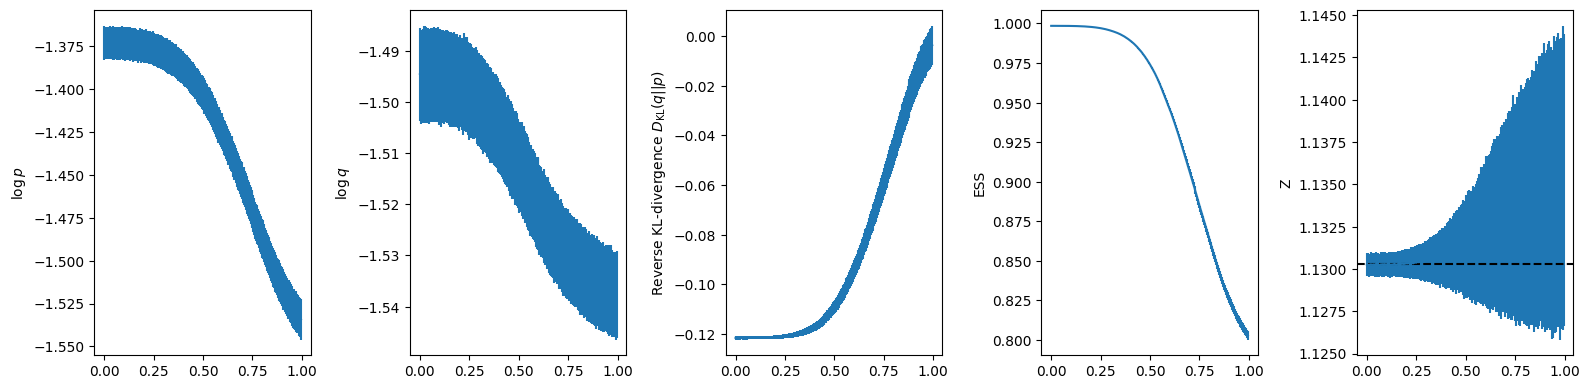

In [34]:
fig, axes = plt.subplots(1, 5, figsize=(16, 4))

axes[0].errorbar(history['t'], history['logp'][0], yerr=history['logp'][1])
axes[0].set_ylabel(r'$\log p$')

axes[1].errorbar(history['t'], history['logq'][0], yerr=history['logq'][1])
axes[1].set_ylabel(r'$\log q$')

axes[2].errorbar(history['t'], history['kl_div'][0], yerr=history['kl_div'][1])
axes[2].set_ylabel(r'Reverse KL-divergence $D_{\rm KL}(q || p)$')

axes[3].errorbar(history['t'], history['ess'][0], yerr=history['ess'][1])
axes[3].set_ylabel('ESS')

axes[4].errorbar(history['t'], history['Z'][0], yerr=history['Z'][1])
axes[4].axhline(true_Z, color='k', linestyle='--')
axes[4].set_ylabel('Z')

fig.tight_layout()
plt.show()

In [35]:
# Model likelihood
logq = logr - logJ
print('avg logq =', logq.mean().item())
print('std logq =', logq.std().item())

avg logq = -1.4947879314422607
std logq = 0.579472541809082


In [36]:
# Target likelihood
logp = -action(U_0) + log_haar_su2(x_0)
print('avg logp =', logp.mean().item())
print('std logp =', logp.std().item())

avg logp = -1.3731391429901123
std logp = 0.6072863340377808


In [37]:
# Effective Sample Size
print('ESS =', compute_ess(logp, logq))

ESS = 0.9984791163643684
